# Display of products and saving in fits format using api.plot_tools

This notebooks documents the functinality of oda_api.plot_tools to visualize images, spectra, and light curves.

Each of these products can also be saved in fits format. The user can add systematic uncertainty to the light curves and spectra; the latter can also be grouped for a quicker fit at the moment of saving files.

Utilities to extract a manipulate the image catalog are also given in order to optimize spectral and 
light curve extraction.

author Carlo Ferrigno (carlo.ferrigno@unige.ch)

In [1]:
source_name="GX 1+4"
tstart='2019-01-01T00:00:00'
tstop='2019-03-31T23:59:59'
n_scw_ima = 10
n_scw_spec_lc = 20
radius_isgri = 8
radius_j1 = 3
run_spec=True
make_image=True
make_j1_image=True
make_lc=True
run_lc_jemx1 = True
e_min = 28.
e_max = 50.
e_min_j1 = 3.
e_max_j1 = 20.
#Note that some of these parameters should be tags for the gallery

In [2]:
from importlib import reload

In [3]:
import logging
#logging.getLogger().setLevel(logging.WARNING)
logging.getLogger().setLevel(logging.INFO) #for more verbose logging

logging.getLogger('').addHandler(logging.StreamHandler()) 

In [4]:
import os,sys
lib_path=os.path.abspath('/home/ferrigno/Soft/oda_api')
if lib_path not in sys.path:
    sys.path.append(lib_path)
else:
    print("Not appending")
import oda_api

## Get the token

In [5]:
import oda_api.token
token = oda_api.token.discover_token()
oda_api.token.decode_oda_token(token)

found token in environment variable ODA_TOKEN your token payload: {
    "email": "Volodymyr.Savchenko@unige.ch",
    "exp": 1642784885.2514007,
    "msdone": false,
    "mssub": false,
    "name": "sitamin",
    "roles": "authenticated user, administrator, content manager, general, integral-private-qla, magic, unige-hpc-full, public-pool-hpc, antares",
    "sub": "Volodymyr.Savchenko@unige.ch"
}
token expires in 1058.7 h


{'sub': 'Volodymyr.Savchenko@unige.ch',
 'email': 'Volodymyr.Savchenko@unige.ch',
 'name': 'sitamin',
 'roles': 'authenticated user, administrator, content manager, general, integral-private-qla, magic, unige-hpc-full, public-pool-hpc, antares',
 'exp': 1642784885.2514007,
 'mssub': False,
 'msdone': False}

In [6]:
from astroquery.simbad import Simbad
from astropy import units as u
from astropy.coordinates import SkyCoord


simbad = Simbad.query_object(source_name)
coord = SkyCoord(simbad['RA'], simbad['DEC'], unit=[u.hour, u.deg])
coord.fk5

#coord = SkyCoord(ra,dec, unit=[u.deg, u.deg])
ra = coord.ra.deg
dec = coord.dec.deg
print("Coordinates for %s are RA=%.4f, Dec=%.4f"%(source_name,ra,dec ) )

Coordinates for GX 1+4 are RA=263.0090, Dec=-24.7456


## We make an image

In [7]:
par_dict = {
"DEC": "%f" % dec,
"E1_keV": e_min,
"E2_keV": e_max,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_isgri,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_ima,
"detection_threshold": "7.0",
"instrument": "isgri",
"integral_data_rights": "public",
"oda_api_version": "1.1.22",
"off_line": "False",
"osa_version": "OSA11.1",
"product": "isgri_image",
"product_type": "Real",

}

In [8]:
import oda_api.api
host="https://www.astro.unige.ch/mmoda/dispatch-data"

disp = oda_api.api.DispatcherAPI(url=host)

if make_image:
    
    isgri_image=disp.get_product(**par_dict)


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
/home/savchenk/.pyenv/versions/3.9.6/lib/python3.9/site-packages/oda_api/api.py:908: UserWarning: 
----------------------------------------------------------------------------
the parameter: oda_api_version   is not among valid ones:
['src_name', 'RA', 'DEC', 'T1', 'T2', 'token', 'scw_list', 'selected_catalog', 'radius', 'max_pointings', 'osa_version', 'integral_data_rights', 'E1_keV', 'E2_keV', 'detection_threshold', 'image_scale_min', 'image_scale_max']
this will throw an error in a future version 
and might break the current request!
 ----------------------------------------------------------------------------

  warnings.warn(msg)
- waiting fo

In [9]:
%matplotlib notebook

## We can look at the image and use sliders to adjust the contrast

In [14]:
isgri_image.mosaic_image_0_mosaic

<IPython.core.display.Javascript object>


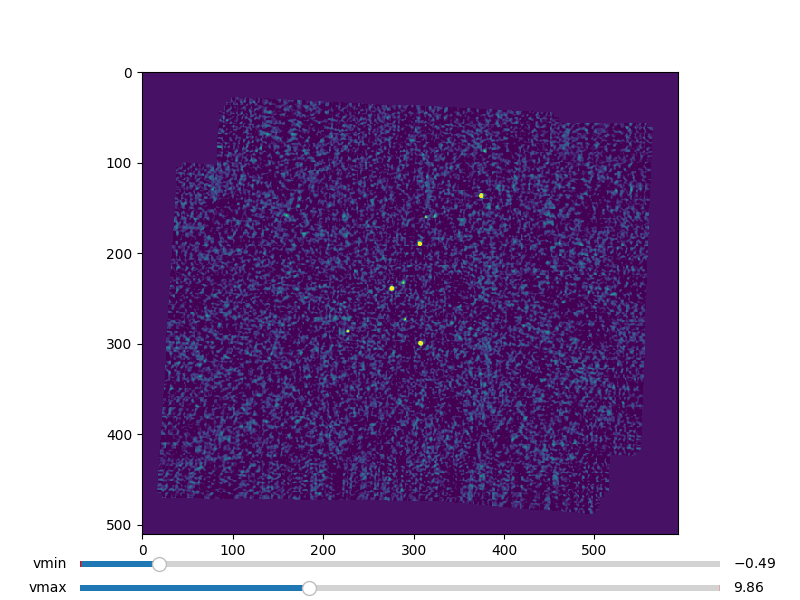

In [15]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
image = oda_api.plot_tools.OdaImage(isgri_image.mosaic_image_0_mosaic)
_=image.show()

# Look on the image with ds9 

Adapted from https://github.com/gijzelaerr/js9notebook

In [18]:
%%html
<div class="JS9Menubar"></div>
<div class="JS9"></div>
<link type="text/css" rel="stylesheet" href="http://js9.si.edu/js9/js9-allinone.css">
<script type="text/javascript" src="http://js9.si.edu/js9/js9-allinone.js"></script>

## We get the catalog from the image to be used in the light curves and spectra
- note that we can add an object of interest in the case it is not detected in the mosaic and to assign a FLAG=1
- Coordinates are derived from Simbad, or dirctly given as objects_of_interest=[(source_name, coord)], see above for the coord definition

In [19]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
image = oda_api.plot_tools.OdaImage(isgri_image)
catalog_string = image.extract_catalog_string_from_image(objects_of_interest=[source_name])

AttributeError: 'OdaImage' object has no attribute 'extract_catalog_string_from_image'

In [ ]:
catalog_string

## We make an imag for JEM-X1 and visualize it

In [ ]:
par_dict = {
"DEC": "%f" % dec,
"E1_keV": e_min_j1,
"E2_keV": e_max_j1,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_j1,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_ima,
"jemx_num": "1",
"osa_version": "OSA11.1",
"detection_threshold": "7.0",
"integral_data_rights": "public",
"instrument": "jemx",
"product": "jemx_image",
"product_type": "Real",
"off_line": "False",
}

In [ ]:
reload(oda_api)
disp = oda_api.api.DispatcherAPI(url=host)

if make_j1_image:
    
    j1_image=disp.get_product(**par_dict)
        


In [ ]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
image = oda_api.plot_tools.OdaImage(j1_image)
_=image.show()

## We can write the image in a fits file

In [ ]:
reload(oda_api.plot_tools)
image = oda_api.plot_tools.OdaImage(j1_image)
image.write_fits('J1_')

## We can make a light curve and simply visualize it
(note that we use the catalog extracted from the image)

In [ ]:
par_dict = {
"DEC": "%f" % dec,
"E1_keV": e_min,
"E2_keV": e_max,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_isgri,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_spec_lc,
"instrument": "isgri",
"integral_data_rights": "public",
"osa_version": "OSA11.1",
"product": "isgri_lc",
"product_type": "Real",
"time_bin": "1000",
"token": token,
"selected_catalog": catalog_string
}


In [ ]:
reload(oda_api)
disp = oda_api.api.DispatcherAPI(url=host)
if make_lc:

    combined_data=disp.get_product(**par_dict)
        
        

In [ ]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
lc = oda_api.plot_tools.OdaLightCurve(combined_data)
_=lc.show(source_name)

## If no source is given all light curves are shown

In [ ]:
_=lc.show()

## We can search for thermonuclear bursts in the JEM-X light curve

In [ ]:
par_dict = {
"DEC": "%f" % dec,
"E1_keV": e_min_j1,
"E2_keV": e_max_j1,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_j1,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_spec_lc,
"instrument": "jemx",
"integral_data_rights": "public",
"jemx_num": "1",
"oda_api_version": "1.1.22",
"off_line": "False",
"osa_version": "OSA11.1",
"product": "jemx_lc",
"product_type": "Real",
"selected_catalog": catalog_string,
"src_name": "1E 1740.7-2942",
"time_bin": "4",
"token": token}

In [ ]:
if run_lc_jemx1 :
    
    disp = oda_api.api.DispatcherAPI(url=host)
        
    combined_data=disp.get_product(**par_dict)


## Advanced display of light curves
- with the keyword ng_sig_limit you can select the limit for variability in standard deviations
- with the keyword find_excesses you can find points above this limit, which can be useful to find thermonuclear bursts 

In [ ]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
lc = oda_api.plot_tools.OdaLightCurve(combined_data)
_=lc.show(source_name, ng_sig_limit=3.0, find_excesses=True)


## This writes the light curve as a fits file

In [ ]:
lc.write_fits(source_name)

## We extact spectral products for JEMX1

In [ ]:
par_dict = {
    "DEC": "%f" % dec,
"E1_keV": e_min_j1,
"E2_keV": e_max_j1,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_j1,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_spec_lc,
"api": "True",
"instrument": "jemx",
"integral_data_rights": "public",
"jemx_num": "1",
"off_line": "False",
"osa_version": "OSA11.1",
"product": "jemx_spectrum",
"product_type": "Real",
"selected_catalog": catalog_string,
"token": token,
}


In [ ]:
j1_spec = disp.get_product(**par_dict)

## If no source is given, one can see the spectra avalable

In [ ]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
spec = oda_api.plot_tools.OdaSpectrum(j1_spec)
spec.show()

In [ ]:
_=spec.show(source_name)

## We extact spectral products for ISGRI

In [ ]:
par_dict = {
"DEC": "%f" % dec,
"E1_keV": e_min,
"E2_keV": e_max,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_isgri,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_spec_lc,
"instrument": "isgri",
"integral_data_rights": "public",
"off_line": "False",
"osa_version": "OSA11.1",
"product": "isgri_spectrum",
"token": token,
    "selected_catalog": catalog_string
}


In [ ]:
isgri_spec = disp.get_product(**par_dict)

## This plots the spectram, it is possible to set limits for the energy range

In [ ]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
spec = oda_api.plot_tools.OdaSpectrum(isgri_spec)
_ = spec.show(source_name, xlim=[20,100])

## This saves spectrum arf and response in a way to be used with xspec 
- systematic fraction adds a systematic fraction to the spectrum
- grouping performs a grouping on the spectrum the argument is [minimum_energy, maximum_energy, bins]
    - bins is the number of bin spaced logarithmically if negative, linearly if positive 

In [ ]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
spec = oda_api.plot_tools.OdaSpectrum(isgri_spec)
spec.write_fits(source_name, systematic_fraction=0.01, grouping=[30,150,-20])